<a href="https://colab.research.google.com/github/TebaSUH/Counrties-Classification/blob/main/GeoGuessr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and spliting the data


In [2]:
from datasets import load_dataset, DatasetDict
import gc

print("Loading GeoGuessr dataset (streaming mode)...")
dataset = load_dataset("marcelomoreno26/geoguessr", split='train', streaming=True)

# Define countries
countries = ['Japan', 'France', 'Mexico'] #try Brazil instead of Mexico
samples_per_country = 400  #Mexico = 400

# Filter data
filtered_data = []
country_counts = {c: 0 for c in countries}

for item in dataset:
    country = item['label']
    if country in countries and country_counts[country] < samples_per_country:
        filtered_data.append({
            'image': item['image'],
            'label': countries.index(country)
        })
        country_counts[country] += 1

        # if sum(country_counts.values()) % 100 == 0:
        #     print(f"Progress: {country_counts}")

    if all(c >= samples_per_country for c in country_counts.values()):
        break

print(f"\nFinal counts: {country_counts}")
print(f"Total: {len(filtered_data)} images")

# Memory cleanup
del dataset
gc.collect()
print("Dataset loading complete, memory cleaned")

Loading GeoGuessr dataset (streaming mode)...


README.md:   0%|          | 0.00/589 [00:00<?, ?B/s]


Final counts: {'Japan': 400, 'France': 400, 'Mexico': 400}
Total: 1200 images
Dataset loading complete, memory cleaned


split to: train, validation and test

In [3]:
from sklearn.model_selection import train_test_split

labels = [item['label'] for item in filtered_data]

# Split: 70% train, 15% validation, 15% test
train_val, test = train_test_split(filtered_data, test_size=0.15, stratify=labels, random_state=42)

train_val_labels = [item['label'] for item in train_val]
train, validation = train_test_split(train_val, test_size=0.176, stratify=train_val_labels, random_state=42)

print(f"Train: {len(train)}")
print(f"Validation: {len(validation)}")
print(f"Test: {len(test)}")

Train: 840
Validation: 180
Test: 180


Plotting and Visualizing

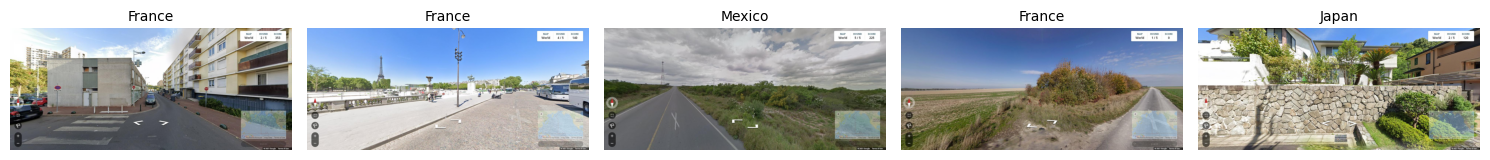

In [4]:
import matplotlib.pyplot as plt

# Show 5 example images
num_examples = 5
examples = train[:num_examples]

plt.figure(figsize=(15, 10))
for i, example in enumerate(examples):
    plt.subplot(1, num_examples, i + 1)
    image = example['image']
    label_idx = example['label']
    country = countries[label_idx]

    plt.imshow(image)
    plt.title(country, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

prepare the model

In [5]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

checkpoint = "google/vit-base-patch16-224"
processor = AutoImageProcessor.from_pretrained(checkpoint)
# Load base model
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(countries),
    ignore_mismatched_sizes=True
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


prepare data for the model


In [6]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class GeoGuessrDataset(Dataset):
    def __init__(self, data, processor, augment=False):
        self.data = data
        self.processor = processor
        self.augment = augment

        self.aug_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']

        if not isinstance(image, Image.Image):
            image = Image.fromarray(np.array(image)).convert('RGB')

        if self.augment:
            image = self.aug_transform(image)

        encoding = self.processor(images=image, return_tensors='pt')
        pixel_values = encoding['pixel_values'].squeeze(0)

        return {
            'pixel_values': pixel_values,
            'labels': torch.tensor(item['label'], dtype=torch.long)
        }


import torch
import numpy as np

train_dataset = GeoGuessrDataset(train, processor, augment=True)
val_dataset = GeoGuessrDataset(validation, processor, augment=False)
test_dataset = GeoGuessrDataset(test, processor, augment=False)

print("Datasets created")

# Memory cleanup
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared")

Datasets created


training

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = predictions.argmax(-1)

  accuracy = accuracy_score(labels, predictions)
  precision, recall, f1, _ = precision_recall_fscore_support(
      labels, predictions, average='weighted'
  )
  return {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
  }
    #TODO: add more args to get better accuarcy
  training_args = TrainingArguments(
      output_dir="geoguessr-vit-finetuned",
      learning_rate=2e-5,
      num_train_epochs=15,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=16,
      gradient_accumulation_steps=2,
      eval_strategy="epoch",
      save_strategy="epoch",
      logging_steps=10,
  )
  trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=val_dataset,
  compute_metrics=compute_metrics,
  )

  print("Start training")
  trainer.train()
  gc.collect()
  if torch.cuda.is_available():
      torch.cuda.empty_cache()